<center>

# R4.A.13 - Lab 3
## Comparing training from scratch vs transfer learning

> Mathieu Stéphan, Lussandre Lederrey, Allan Maccrez

</center>

In this notebook, we will compare the performance of training a model from scratch, using CNN-based feature extraction and fine-tuning.  
We will use the `CIFAR-10` dataset and three networks : `ResNet`, `SqueezeNet` and `VGG`.


---


## Part 0 : Setting up the environment


In [1]:
import pandas as pd
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

# fix random seed for reproducibility
np.random.seed(7)
torch.manual_seed(7)

# moves your model to train on your gpu if available else it uses your cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# check GPU
!nvidia-smi


Using device: cuda
Sat Jun  1 15:48:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:07:00.0  On |                  N/A |
| 30%   49C    P8             19W /  220W |    1317MiB /  12282MiB |     29%      Default |
|                                         |                        |                  N/A |
+----------------------------

> Note : run the following command in the terminal if you get errors :

```bash
pip install -U pandas numpy matplotlib torch torchvision
```


## Get the dataset and create the dataloaders


Files already downloaded and verified
Files already downloaded and verified
Train size :  50000
Validation size :  10000
torch.Size([64, 3, 32, 32])
torch.Size([64])


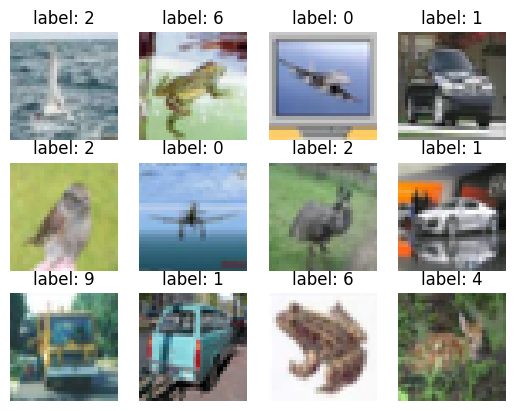

In [2]:
# Define transform to normalize data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data and the validation (test) data
train_set = datasets.CIFAR10("DATA_CIFAR/", download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

validation_set = datasets.CIFAR10("DATA_CIFAR/", download=True, train=False, transform=transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=True)

# show the training size, test size, number of classes
print("Train size : ", len(train_set))
print("Validation size : ", len(validation_set))

# check the size of the image tensors and label tensors
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(images.shape)
print(labels.shape)

# Display some image samples
for i in range(0, 12):
    plt.subplot(3, 4, i + 1)
    plt.imshow((images[i] / 2 + 0.5).permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title("label: " + str(labels[i].numpy().squeeze()))
plt.show()


---


## Part 1 : `ResNet`
### Step 1 : Training from scratch
Here we define a simple CNN model and train it from scratch on the `CIFAR-10` dataset.


In [3]:
class CNN_cifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN_cifar().to(device)


Training function for the model :


In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_loss, val_loss = [], []
    accuracy_total_train, accuracy_total_val = [], []

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
                dataloader = trainLoader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = validationLoader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            if phase == "train":
                train_loss.append(epoch_loss)
                accuracy_total_train.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                accuracy_total_val.append(epoch_acc)

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))

    return model, train_loss, val_loss, accuracy_total_train, accuracy_total_val, time_elapsed / num_epochs


Train the model from scratch :


Epoch 0/9
----------
train Loss: 1.7636 Acc: 0.3605
val Loss: 1.4436 Acc: 0.4839
Epoch 1/9
----------
train Loss: 1.3278 Acc: 0.5242
val Loss: 1.2117 Acc: 0.5676
Epoch 2/9
----------
train Loss: 1.1313 Acc: 0.5988
val Loss: 1.0780 Acc: 0.6181
Epoch 3/9
----------
train Loss: 0.9880 Acc: 0.6527
val Loss: 0.9931 Acc: 0.6515
Epoch 4/9
----------
train Loss: 0.8828 Acc: 0.6899
val Loss: 0.9025 Acc: 0.6809
Epoch 5/9
----------
train Loss: 0.7956 Acc: 0.7209
val Loss: 0.8657 Acc: 0.6987
Epoch 6/9
----------
train Loss: 0.7182 Acc: 0.7498
val Loss: 0.8669 Acc: 0.6955
Epoch 7/9
----------
train Loss: 0.5734 Acc: 0.8052
val Loss: 0.7876 Acc: 0.7296
Epoch 8/9
----------
train Loss: 0.5466 Acc: 0.8132
val Loss: 0.7871 Acc: 0.7306
Epoch 9/9
----------
train Loss: 0.5324 Acc: 0.8182
val Loss: 0.7849 Acc: 0.7325
Training complete in 3m 16s


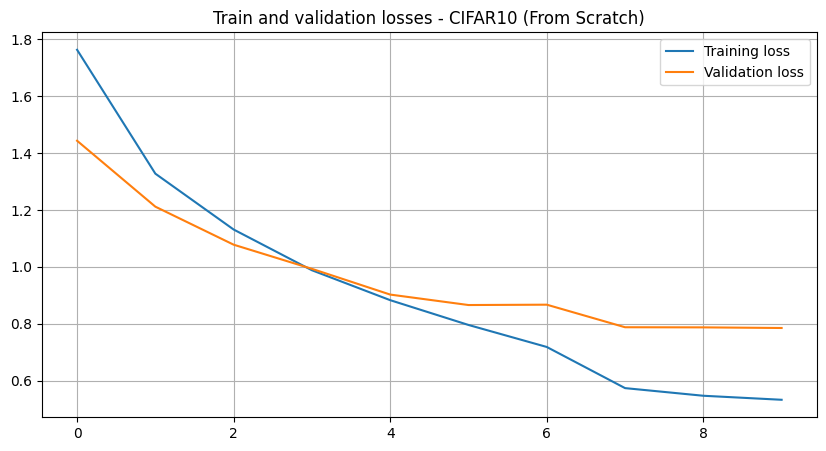

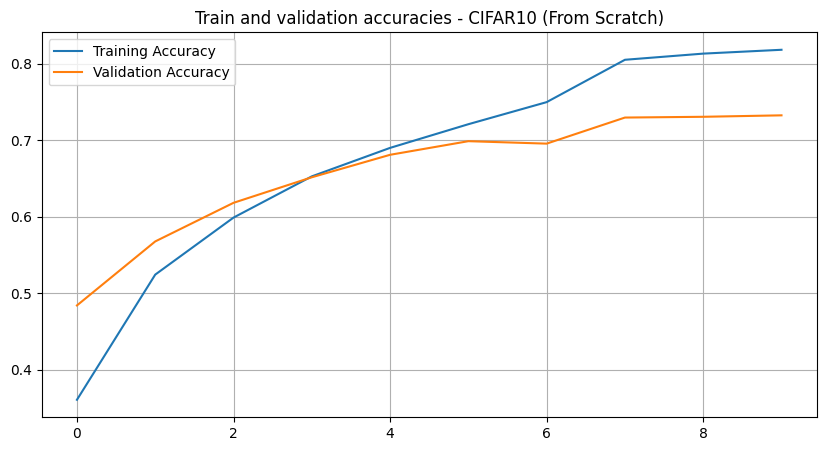

In [5]:
# Training from scratch
model_scratch = CNN_cifar().to(device)
criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.003, momentum=0.9)
scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

model_scratch, train_loss_scratch, val_loss_scratch, accuracy_total_train_scratch, accuracy_total_val_scratch, time_per_epoch_scratch = train_model(model_scratch, criterion_scratch, optimizer_scratch, scheduler_scratch, num_epochs=10)

# Convert accuracy lists to numpy arrays
accuracy_total_train_scratch = [acc.cpu().numpy() for acc in accuracy_total_train_scratch]
accuracy_total_val_scratch = [acc.cpu().numpy() for acc in accuracy_total_val_scratch]

# Plot the loss curve for training from scratch
plt.figure(figsize=(10, 5))
plt.plot(train_loss_scratch, label="Training loss")
plt.plot(val_loss_scratch, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (From Scratch)")
plt.show()

# Plot the accuracy curve for training from scratch
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_scratch, label="Training Accuracy")
plt.plot(accuracy_total_val_scratch, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (From Scratch)")
plt.show()


### Step 2 : Feature extraction with `ResNet18`
In this section, we use a pre-trained `ResNet18` model and only train the final fully connected layer (feature extraction).


Files already downloaded and verified
Files already downloaded and verified
Epoch 0/19
----------
train Loss: 1.7709 Acc: 0.3840
val Loss: 1.6406 Acc: 0.4375
Epoch 1/19
----------
train Loss: 1.5999 Acc: 0.4418
val Loss: 1.5921 Acc: 0.4571
Epoch 2/19
----------
train Loss: 1.5720 Acc: 0.4515
val Loss: 1.5908 Acc: 0.4502
Epoch 3/19
----------
train Loss: 1.5607 Acc: 0.4571
val Loss: 1.5761 Acc: 0.4608
Epoch 4/19
----------
train Loss: 1.5494 Acc: 0.4600
val Loss: 1.5674 Acc: 0.4639
Epoch 5/19
----------
train Loss: 1.5445 Acc: 0.4624
val Loss: 1.5598 Acc: 0.4605
Epoch 6/19
----------
train Loss: 1.5417 Acc: 0.4607
val Loss: 1.5685 Acc: 0.4526
Epoch 7/19
----------
train Loss: 1.5098 Acc: 0.4765
val Loss: 1.5378 Acc: 0.4700
Epoch 8/19
----------
train Loss: 1.5115 Acc: 0.4772
val Loss: 1.5287 Acc: 0.4745
Epoch 9/19
----------
train Loss: 1.5094 Acc: 0.4752
val Loss: 1.5475 Acc: 0.4691
Epoch 10/19
----------
train Loss: 1.5066 Acc: 0.4762
val Loss: 1.5366 Acc: 0.4744
Epoch 11/19
---------

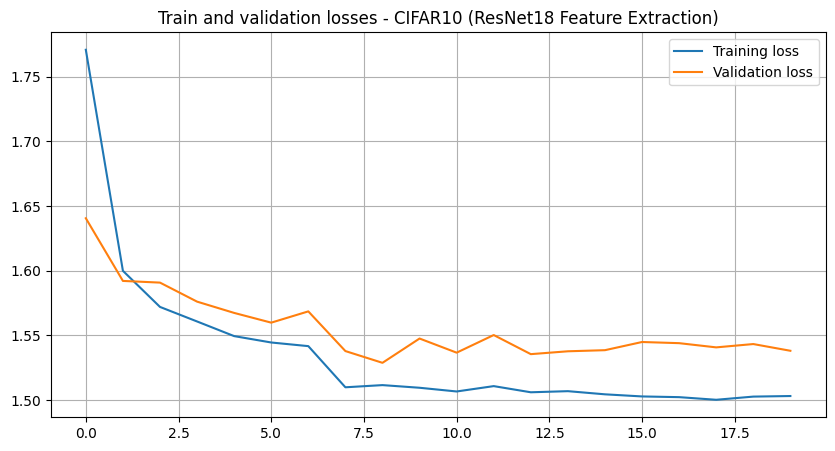

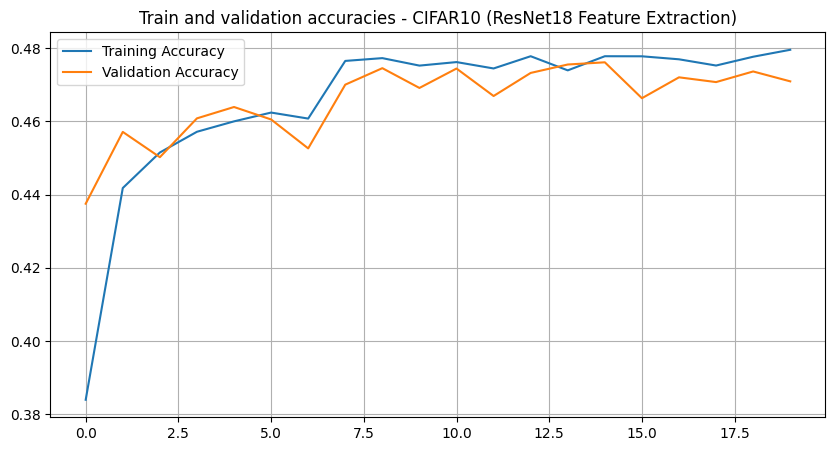

In [6]:
transform_resnet = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Download and load the training data and the validation (test) data for ResNet
train_set_resnet = datasets.CIFAR10("DATA_CIFAR/", download=True, train=True, transform=transform_resnet)
trainLoader_resnet = torch.utils.data.DataLoader(train_set_resnet, batch_size=64, shuffle=True)

validation_set_resnet = datasets.CIFAR10("DATA_CIFAR/", download=True, train=False, transform=transform_resnet)
validationLoader_resnet = torch.utils.data.DataLoader(validation_set_resnet, batch_size=64, shuffle=True)

model_conv = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)
model_conv = model_conv.to(device)

criterion_conv = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
scheduler_conv = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train model with feature extraction
model_conv, train_loss_conv, val_loss_conv, accuracy_total_train_conv, accuracy_total_val_conv, time_per_epoch_conv = train_model(model_conv, criterion_conv, optimizer_conv, scheduler_conv, num_epochs=20)

# Convert accuracy lists to numpy arrays
accuracy_total_train_conv = [acc.cpu().numpy() for acc in accuracy_total_train_conv]
accuracy_total_val_conv = [acc.cpu().numpy() for acc in accuracy_total_val_conv]

# Plot the loss curve for feature extraction
plt.figure(figsize=(10, 5))
plt.plot(train_loss_conv, label="Training loss")
plt.plot(val_loss_conv, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (ResNet18 Feature Extraction)")
plt.show()

# Plot the accuracy curve for feature extraction
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_conv, label="Training Accuracy")
plt.plot(accuracy_total_val_conv, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (ResNet18 Feature Extraction)")
plt.show()


### Step 3 : Fine-tuning with `ResNet18`
In this section, we fine-tune the entire `ResNet18` model on the `CIFAR-10` dataset.


Epoch 0/19
----------
train Loss: 1.0348 Acc: 0.6389
val Loss: 0.7381 Acc: 0.7436
Epoch 1/19
----------
train Loss: 0.6346 Acc: 0.7797
val Loss: 0.6346 Acc: 0.7792
Epoch 2/19
----------
train Loss: 0.4797 Acc: 0.8325
val Loss: 0.6005 Acc: 0.7958
Epoch 3/19
----------
train Loss: 0.3759 Acc: 0.8683
val Loss: 0.6151 Acc: 0.7989
Epoch 4/19
----------
train Loss: 0.2881 Acc: 0.8990
val Loss: 0.6415 Acc: 0.8025
Epoch 5/19
----------
train Loss: 0.2236 Acc: 0.9210
val Loss: 0.6741 Acc: 0.8044
Epoch 6/19
----------
train Loss: 0.1777 Acc: 0.9372
val Loss: 0.7300 Acc: 0.8016
Epoch 7/19
----------
train Loss: 0.1016 Acc: 0.9679
val Loss: 0.6928 Acc: 0.8114
Epoch 8/19
----------
train Loss: 0.0806 Acc: 0.9754
val Loss: 0.7061 Acc: 0.8112
Epoch 9/19
----------
train Loss: 0.0718 Acc: 0.9785
val Loss: 0.7138 Acc: 0.8127
Epoch 10/19
----------
train Loss: 0.0625 Acc: 0.9819
val Loss: 0.7278 Acc: 0.8133
Epoch 11/19
----------
train Loss: 0.0586 Acc: 0.9827
val Loss: 0.7338 Acc: 0.8154
Epoch 12/19
--

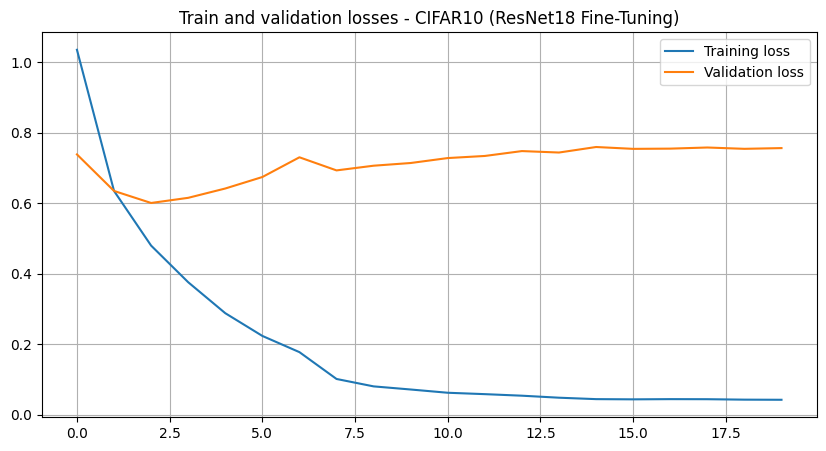

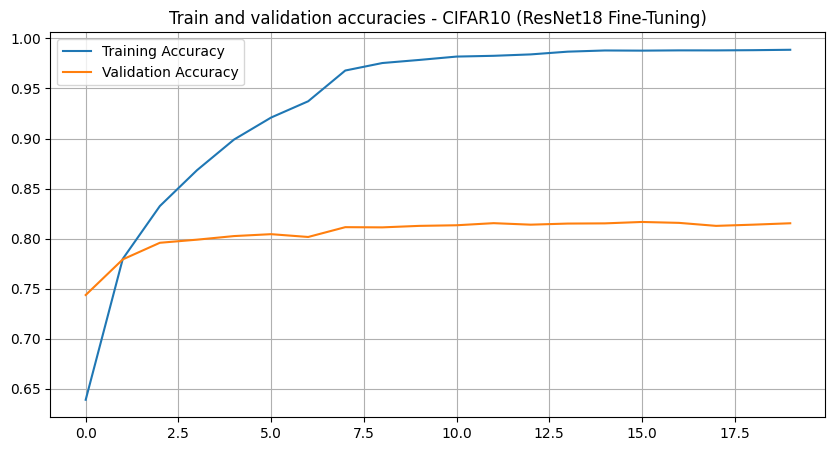

In [7]:
# Fine-tuning with ResNet18
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)
model_ft = model_ft.to(device)

criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train model with fine-tuning
model_ft, train_loss_ft, val_loss_ft, accuracy_total_train_ft, accuracy_total_val_ft, time_per_epoch_ft = train_model(model_ft, criterion_ft, optimizer_ft, scheduler_ft, num_epochs=20)

# Convert accuracy lists to numpy arrays
accuracy_total_train_ft = [acc.cpu().numpy() for acc in accuracy_total_train_ft]
accuracy_total_val_ft = [acc.cpu().numpy() for acc in accuracy_total_val_ft]

# Plot the loss curve for fine-tuning
plt.figure(figsize=(10, 5))
plt.plot(train_loss_ft, label="Training loss")
plt.plot(val_loss_ft, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (ResNet18 Fine-Tuning)")
plt.show()

# Plot the accuracy curve for fine-tuning
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_ft, label="Training Accuracy")
plt.plot(accuracy_total_val_ft, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (ResNet18 Fine-Tuning)")
plt.show()


### Step 4 : Comparative analysis
Finally, we summarize the results in a comparative table.


In [8]:
# Create the ResNet comparison DataFrame
data = {
    "Model": ["From Scratch", "ResNet18 (Feature Extraction)", "ResNet18 (Fine-Tuning)"],
    "Number of Trainable Params": [
        sum(p.numel() for p in model_scratch.parameters() if p.requires_grad),
        sum(p.numel() for p in model_conv.parameters() if p.requires_grad),
        sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
    ],
    "Test Accuracy": [
        accuracy_total_val_scratch[-1].item(),
        accuracy_total_val_conv[-1].item(),
        accuracy_total_val_ft[-1].item()
    ],
    "Training Time per Epoch": [
        time_per_epoch_scratch,
        time_per_epoch_conv,
        time_per_epoch_ft
    ]
}

df = pd.DataFrame(data)
print(df)


                           Model  Number of Trainable Params  Test Accuracy  \
0                   From Scratch                      579402         0.7325   
1  ResNet18 (Feature Extraction)                        5130         0.4709   
2         ResNet18 (Fine-Tuning)                    11181642         0.8153   

   Training Time per Epoch  
0                19.556096  
1                21.722634  
2                25.539238  


---


## Part 2 : `SqueezeNet`
### Step 1 : Training from scratch
Here we define a custom `SqueezeNet`-like model and train it from scratch on the `CIFAR-10` dataset.


In [9]:
class Fire(nn.Module):
    def __init__(self, in_channels, squeeze_channels, expand1x1_channels, expand3x3_channels):
        super(Fire, self).__init__()
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_channels, expand1x1_channels, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_channels, expand3x3_channels, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet_cifar(nn.Module):
    def __init__(self):
        super(SqueezeNet_cifar, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fire2 = Fire(96, 16, 64, 64)
        self.fire3 = Fire(128, 16, 64, 64)
        self.fire4 = Fire(128, 32, 128, 128)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fire5 = Fire(256, 32, 128, 128)
        self.fire6 = Fire(256, 48, 192, 192)
        self.fire7 = Fire(384, 48, 192, 192)
        self.fire8 = Fire(384, 64, 256, 256)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fire9 = Fire(512, 64, 256, 256)
        self.conv2 = nn.Conv2d(512, 10, kernel_size=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.maxpool2(x)
        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.maxpool3(x)
        x = self.fire9(x)
        x = self.conv2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

model_squeeze = SqueezeNet_cifar().to(device)


Train the `SqueezeNet` model from scratch :


Epoch 0/9
----------
train Loss: 2.3029 Acc: 0.0980
val Loss: 2.3027 Acc: 0.1000
Epoch 1/9
----------
train Loss: 2.3028 Acc: 0.0995
val Loss: 2.3027 Acc: 0.1000
Epoch 2/9
----------
train Loss: 2.3029 Acc: 0.0986
val Loss: 2.3026 Acc: 0.1000
Epoch 3/9
----------
train Loss: 2.3029 Acc: 0.0989
val Loss: 2.3027 Acc: 0.1000
Epoch 4/9
----------
train Loss: 2.3028 Acc: 0.1001
val Loss: 2.3027 Acc: 0.1000
Epoch 5/9
----------
train Loss: 2.3029 Acc: 0.0970
val Loss: 2.3027 Acc: 0.1000
Epoch 6/9
----------
train Loss: 2.3028 Acc: 0.0962
val Loss: 2.3027 Acc: 0.1000
Epoch 7/9
----------
train Loss: 2.3027 Acc: 0.1000
val Loss: 2.3026 Acc: 0.1000
Epoch 8/9
----------
train Loss: 2.3026 Acc: 0.0996
val Loss: 2.3026 Acc: 0.1000
Epoch 9/9
----------
train Loss: 2.3026 Acc: 0.0972
val Loss: 2.3026 Acc: 0.1000
Training complete in 4m 3s


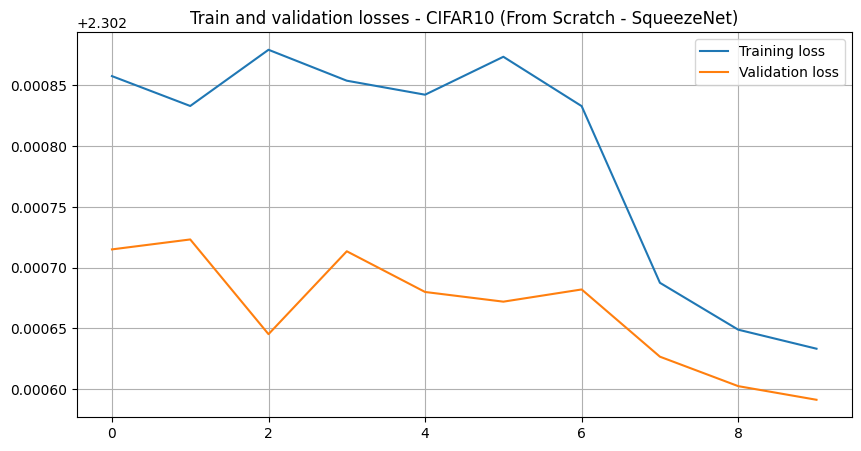

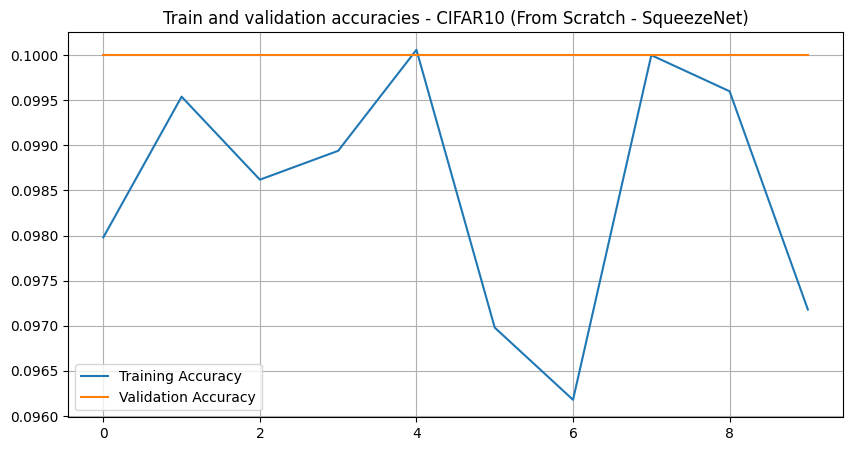

In [10]:
# Training from scratch
criterion_squeeze = nn.CrossEntropyLoss()
optimizer_squeeze = optim.SGD(model_squeeze.parameters(), lr=0.003, momentum=0.9)
scheduler_squeeze = lr_scheduler.StepLR(optimizer_squeeze, step_size=7, gamma=0.1)

model_squeeze, train_loss_squeeze, val_loss_squeeze, accuracy_total_train_squeeze, accuracy_total_val_squeeze, time_per_epoch_squeeze = train_model(model_squeeze, criterion_squeeze, optimizer_squeeze, scheduler_squeeze, num_epochs=10)

# Convert accuracy lists to numpy arrays
accuracy_total_train_squeeze = [acc.cpu().numpy() for acc in accuracy_total_train_squeeze]
accuracy_total_val_squeeze = [acc.cpu().numpy() for acc in accuracy_total_val_squeeze]

# Plot the loss curve for training from scratch (SqueezeNet)
plt.figure(figsize=(10, 5))
plt.plot(train_loss_squeeze, label="Training loss")
plt.plot(val_loss_squeeze, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (From Scratch - SqueezeNet)")
plt.show()

# Plot the accuracy curve for training from scratch (SqueezeNet)
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_squeeze, label="Training Accuracy")
plt.plot(accuracy_total_val_squeeze, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (From Scratch - SqueezeNet)")
plt.show()


### Step 2 : Feature extraction with `SqueezeNet`
Here we use a pre-trained `SqueezeNet` model and only train the final fully connected layer (feature extraction).


Files already downloaded and verified
Files already downloaded and verified


c:\Users\Mat\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mat\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Mat\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_w

Epoch 0/19
----------
train Loss: 2.3343 Acc: 0.1015
val Loss: 2.3017 Acc: 0.1004
Epoch 1/19
----------
train Loss: 2.3026 Acc: 0.1011
val Loss: 2.3026 Acc: 0.1000
Epoch 2/19
----------
train Loss: 2.3024 Acc: 0.1004
val Loss: 2.3026 Acc: 0.1000
Epoch 3/19
----------
train Loss: 2.3012 Acc: 0.1015
val Loss: 2.3024 Acc: 0.1001
Epoch 4/19
----------
train Loss: 2.3024 Acc: 0.1008
val Loss: 2.3024 Acc: 0.1001
Epoch 5/19
----------
train Loss: 2.3031 Acc: 0.1012
val Loss: 2.3024 Acc: 0.1001
Epoch 6/19
----------
train Loss: 2.3010 Acc: 0.1011
val Loss: 2.3024 Acc: 0.1001
Epoch 7/19
----------
train Loss: 2.3010 Acc: 0.1014
val Loss: 2.3024 Acc: 0.1001
Epoch 8/19
----------
train Loss: 2.3016 Acc: 0.1018
val Loss: 2.3024 Acc: 0.1001
Epoch 9/19
----------
train Loss: 2.3006 Acc: 0.1017
val Loss: 2.3021 Acc: 0.1003
Epoch 10/19
----------
train Loss: 2.2994 Acc: 0.1024
val Loss: 2.3014 Acc: 0.1008
Epoch 11/19
----------
train Loss: 2.3017 Acc: 0.1031
val Loss: 2.3009 Acc: 0.1009
Epoch 12/19
--

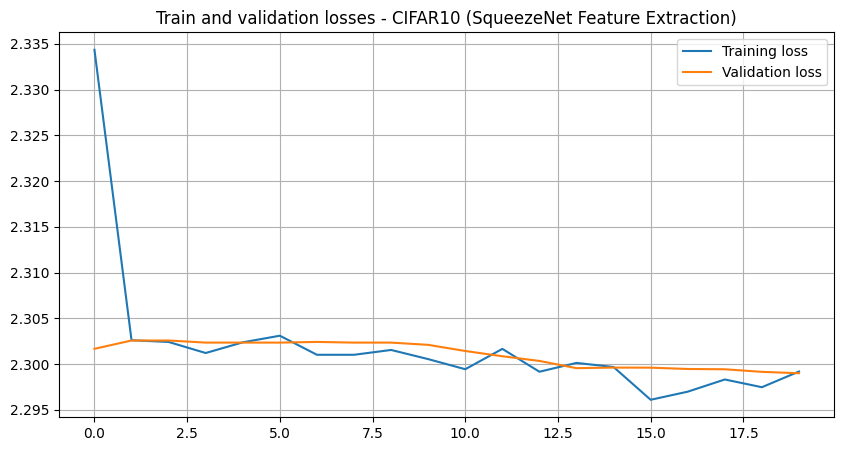

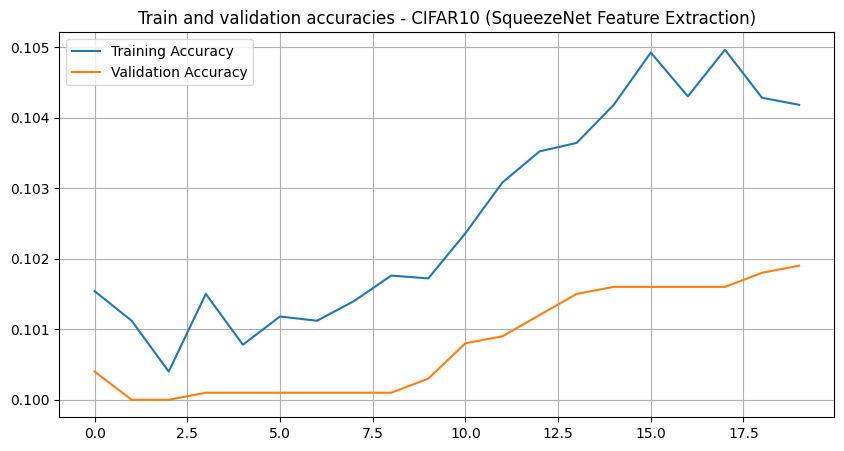

In [11]:
transform_squeezenet = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Download and load the training data and the validation (test) data for SqueezeNet
train_set_squeezenet = datasets.CIFAR10("DATA_CIFAR/", download=True, train=True, transform=transform_squeezenet)
trainLoader_squeezenet = torch.utils.data.DataLoader(train_set_squeezenet, batch_size=64, shuffle=True)

validation_set_squeezenet = datasets.CIFAR10("DATA_CIFAR/", download=True, train=False, transform=transform_squeezenet)
validationLoader_squeezenet = torch.utils.data.DataLoader(validation_set_squeezenet, batch_size=64, shuffle=True)

model_conv_squeeze = models.squeezenet1_0(pretrained=True)
for param in model_conv_squeeze.parameters():
    param.requires_grad = False

model_conv_squeeze.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
model_conv_squeeze.num_classes = 10
model_conv_squeeze = model_conv_squeeze.to(device)

criterion_conv_squeeze = nn.CrossEntropyLoss()
optimizer_conv_squeeze = optim.SGD(model_conv_squeeze.classifier[1].parameters(), lr=0.001, momentum=0.9)
scheduler_conv_squeeze = lr_scheduler.StepLR(optimizer_conv_squeeze, step_size=7, gamma=0.1)

# Train model with feature extraction
model_conv_squeeze, train_loss_conv_squeeze, val_loss_conv_squeeze, accuracy_total_train_conv_squeeze, accuracy_total_val_conv_squeeze, time_per_epoch_conv_squeeze = train_model(model_conv_squeeze, criterion_conv_squeeze, optimizer_conv_squeeze, scheduler_conv_squeeze, num_epochs=20)

# Convert accuracy lists to numpy arrays
accuracy_total_train_conv_squeeze = [acc.cpu().numpy() for acc in accuracy_total_train_conv_squeeze]
accuracy_total_val_conv_squeeze = [acc.cpu().numpy() for acc in accuracy_total_val_conv_squeeze]

# Plot the loss curve for feature extraction (SqueezeNet)
plt.figure(figsize=(10, 5))
plt.plot(train_loss_conv_squeeze, label="Training loss")
plt.plot(val_loss_conv_squeeze, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (SqueezeNet Feature Extraction)")
plt.show()

# Plot the accuracy curve for feature extraction (SqueezeNet)
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_conv_squeeze, label="Training Accuracy")
plt.plot(accuracy_total_val_conv_squeeze, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (SqueezeNet Feature Extraction)")
plt.show()


### Step 3 : Fine-tuning with `SqueezeNet`
Here we fine-tune the entire `SqueezeNet` model on the `CIFAR-10` dataset.


Epoch 0/19
----------


c:\Users\Mat\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


train Loss: 2.1717 Acc: 0.1962
val Loss: 1.5273 Acc: 0.4709
Epoch 1/19
----------
train Loss: 1.3023 Acc: 0.5422
val Loss: 1.0020 Acc: 0.6521
Epoch 2/19
----------
train Loss: 1.0253 Acc: 0.6517
val Loss: 0.9036 Acc: 0.6876
Epoch 3/19
----------
train Loss: 0.8997 Acc: 0.6975
val Loss: 0.8449 Acc: 0.7068
Epoch 4/19
----------
train Loss: 0.8064 Acc: 0.7278
val Loss: 0.7870 Acc: 0.7318
Epoch 5/19
----------
train Loss: 0.7435 Acc: 0.7475
val Loss: 0.8428 Acc: 0.7119
Epoch 6/19
----------
train Loss: 0.6914 Acc: 0.7682
val Loss: 0.7401 Acc: 0.7412
Epoch 7/19
----------
train Loss: 0.5758 Acc: 0.8059
val Loss: 0.7060 Acc: 0.7587
Epoch 8/19
----------
train Loss: 0.5566 Acc: 0.8115
val Loss: 0.7060 Acc: 0.7624
Epoch 9/19
----------
train Loss: 0.5473 Acc: 0.8141
val Loss: 0.7119 Acc: 0.7569
Epoch 10/19
----------
train Loss: 0.5376 Acc: 0.8192
val Loss: 0.7009 Acc: 0.7614
Epoch 11/19
----------
train Loss: 0.5311 Acc: 0.8205
val Loss: 0.7049 Acc: 0.7620
Epoch 12/19
----------
train Loss: 0

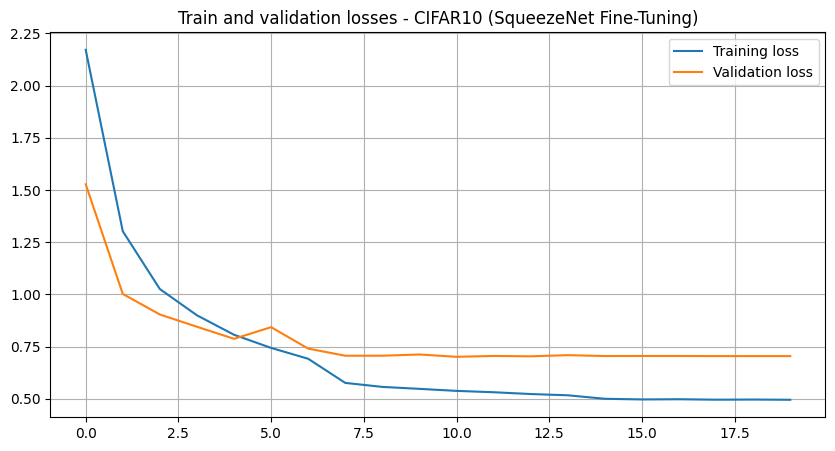

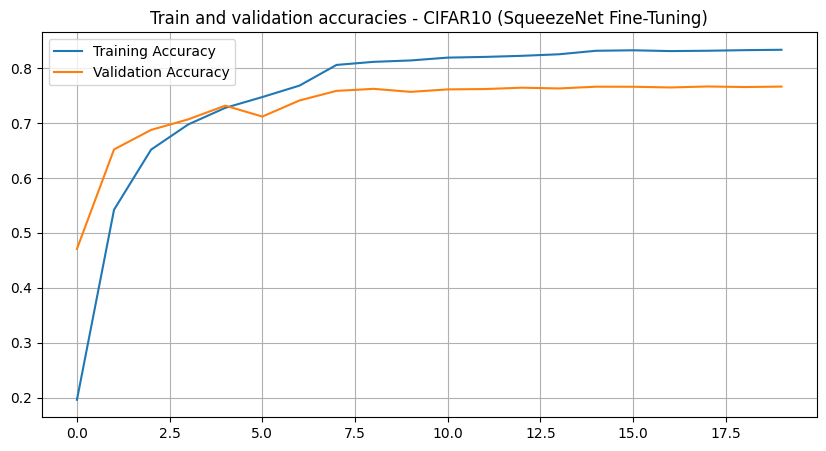

In [12]:
# Fine-tuning with SqueezeNet
model_ft_squeeze = models.squeezenet1_0(pretrained=True)
model_ft_squeeze.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
model_ft_squeeze.num_classes = 10
model_ft_squeeze = model_ft_squeeze.to(device)

criterion_ft_squeeze = nn.CrossEntropyLoss()
optimizer_ft_squeeze = optim.SGD(model_ft_squeeze.parameters(), lr=0.001, momentum=0.9)
scheduler_ft_squeeze = lr_scheduler.StepLR(optimizer_ft_squeeze, step_size=7, gamma=0.1)

# Train model with fine-tuning
model_ft_squeeze, train_loss_ft_squeeze, val_loss_ft_squeeze, accuracy_total_train_ft_squeeze, accuracy_total_val_ft_squeeze, time_per_epoch_ft_squeeze = train_model(model_ft_squeeze, criterion_ft_squeeze, optimizer_ft_squeeze, scheduler_ft_squeeze, num_epochs=20)

# Convert accuracy lists to numpy arrays
accuracy_total_train_ft_squeeze = [acc.cpu().numpy() for acc in accuracy_total_train_ft_squeeze]
accuracy_total_val_ft_squeeze = [acc.cpu().numpy() for acc in accuracy_total_val_ft_squeeze]

# Plot the loss curve for fine-tuning (SqueezeNet)
plt.figure(figsize=(10, 5))
plt.plot(train_loss_ft_squeeze, label="Training loss")
plt.plot(val_loss_ft_squeeze, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (SqueezeNet Fine-Tuning)")
plt.show()

# Plot the accuracy curve for fine-tuning (SqueezeNet)
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_ft_squeeze, label="Training Accuracy")
plt.plot(accuracy_total_val_ft_squeeze, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (SqueezeNet Fine-Tuning)")
plt.show()


### Step 4 : Comparative analysis
We summarize the results in a comparative table.


In [13]:
# Create the ResNet and SqueezeNet comparison DataFrame
data = {
    "Model": [
        "From Scratch (ResNet18)", "ResNet18 (Feature Extraction)", "ResNet18 (Fine-Tuning)",
        "From Scratch (SqueezeNet)", "SqueezeNet (Feature Extraction)", "SqueezeNet (Fine-Tuning)"
    ],
    "Number of Trainable Params": [
        sum(p.numel() for p in model_scratch.parameters() if p.requires_grad),
        sum(p.numel() for p in model_conv.parameters() if p.requires_grad),
        sum(p.numel() for p in model_ft.parameters() if p.requires_grad),
        sum(p.numel() for p in model_squeeze.parameters() if p.requires_grad),
        sum(p.numel() for p in model_conv_squeeze.parameters() if p.requires_grad),
        sum(p.numel() for p in model_ft_squeeze.parameters() if p.requires_grad)
    ],
    "Test Accuracy": [
        accuracy_total_val_scratch[-1].item(),
        accuracy_total_val_conv[-1].item(),
        accuracy_total_val_ft[-1].item(),
        accuracy_total_val_squeeze[-1].item(),
        accuracy_total_val_conv_squeeze[-1].item(),
        accuracy_total_val_ft_squeeze[-1].item()
    ],
    "Training Time per Epoch": [
        time_per_epoch_scratch,
        time_per_epoch_conv,
        time_per_epoch_ft,
        time_per_epoch_squeeze,
        time_per_epoch_conv_squeeze,
        time_per_epoch_ft_squeeze
    ]
}

df = pd.DataFrame(data)
print(df)


                             Model  Number of Trainable Params  Test Accuracy  \
0          From Scratch (ResNet18)                      579402         0.7325   
1    ResNet18 (Feature Extraction)                        5130         0.4709   
2           ResNet18 (Fine-Tuning)                    11181642         0.8153   
3        From Scratch (SqueezeNet)                      729034         0.1000   
4  SqueezeNet (Feature Extraction)                        5130         0.1019   
5         SqueezeNet (Fine-Tuning)                      740554         0.7665   

   Training Time per Epoch  
0                19.556096  
1                21.722634  
2                25.539238  
3                24.277513  
4                19.641536  
5                24.438097  


---


## Part 3 : `VGG`
### Step 1 : Training from scratch
Here we define a custom `VGG`-like model and train it from scratch on the `CIFAR-10` dataset.


In [14]:
class VGG_cifar(nn.Module):
    def __init__(self):
        super(VGG_cifar, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_vgg = VGG_cifar().to(device)


Train the `VGG` model from scratch :


Epoch 0/9
----------
train Loss: 2.3029 Acc: 0.0980
val Loss: 2.3026 Acc: 0.1000
Epoch 1/9
----------
train Loss: 2.3028 Acc: 0.0995
val Loss: 2.3028 Acc: 0.1000
Epoch 2/9
----------
train Loss: 2.3028 Acc: 0.0999
val Loss: 2.3027 Acc: 0.1000
Epoch 3/9
----------
train Loss: 2.3029 Acc: 0.1011
val Loss: 2.3027 Acc: 0.1000
Epoch 4/9
----------
train Loss: 2.3028 Acc: 0.0999
val Loss: 2.3026 Acc: 0.1000
Epoch 5/9
----------
train Loss: 2.3029 Acc: 0.0971
val Loss: 2.3027 Acc: 0.1000
Epoch 6/9
----------
train Loss: 2.3028 Acc: 0.0999
val Loss: 2.3027 Acc: 0.1000
Epoch 7/9
----------
train Loss: 2.3027 Acc: 0.1002
val Loss: 2.3026 Acc: 0.1000
Epoch 8/9
----------
train Loss: 2.3026 Acc: 0.0994
val Loss: 2.3026 Acc: 0.1000
Epoch 9/9
----------
train Loss: 2.3027 Acc: 0.1002
val Loss: 2.3026 Acc: 0.1000
Training complete in 4m 8s


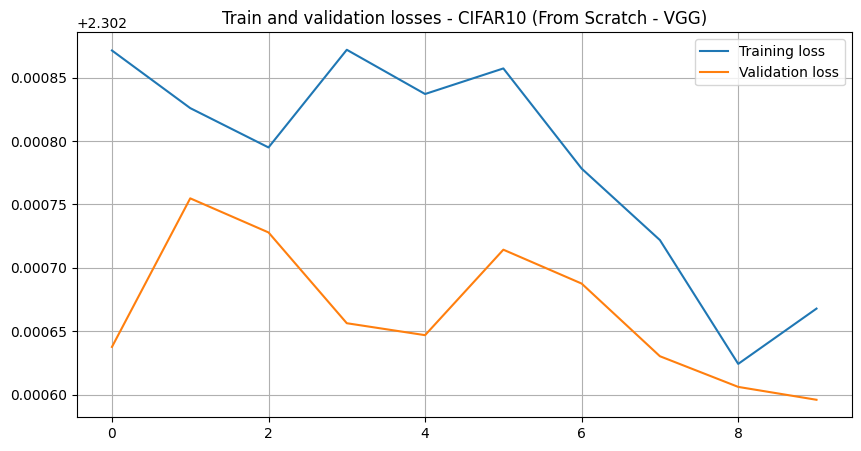

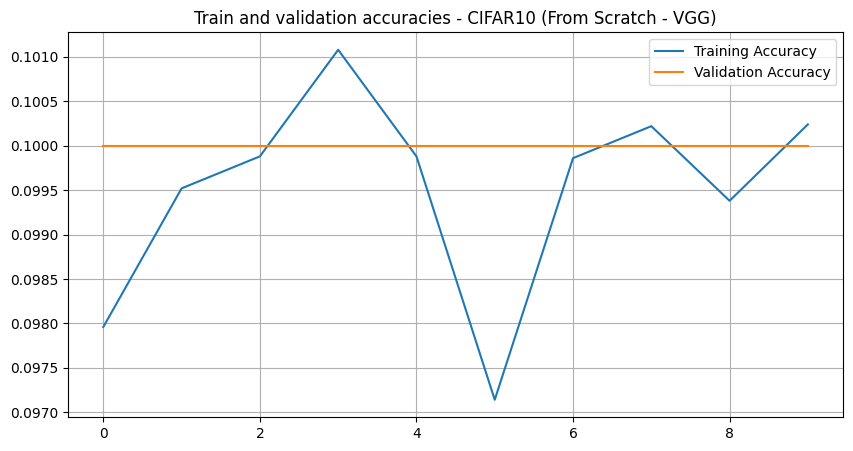

In [15]:
# Training from scratch
criterion_vgg = nn.CrossEntropyLoss()
optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.003, momentum=0.9)
scheduler_vgg = lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)

model_vgg, train_loss_vgg, val_loss_vgg, accuracy_total_train_vgg, accuracy_total_val_vgg, time_per_epoch_vgg = train_model(model_vgg, criterion_vgg, optimizer_vgg, scheduler_vgg, num_epochs=10)

# Convert accuracy lists to numpy arrays
accuracy_total_train_vgg = [acc.cpu().numpy() for acc in accuracy_total_train_vgg]
accuracy_total_val_vgg = [acc.cpu().numpy() for acc in accuracy_total_val_vgg]

# Plot the loss curve for training from scratch (VGG)
plt.figure(figsize=(10, 5))
plt.plot(train_loss_vgg, label="Training loss")
plt.plot(val_loss_vgg, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (From Scratch - VGG)")
plt.show()

# Plot the accuracy curve for training from scratch (VGG)
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_vgg, label="Training Accuracy")
plt.plot(accuracy_total_val_vgg, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (From Scratch - VGG)")
plt.show()


### Step 2 : Feature extraction with `VGG`
Here we use a pre-trained `VGG` model and only train the final fully connected layer (feature extraction).


Files already downloaded and verified
Files already downloaded and verified


c:\Users\Mat\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Mat\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Mat/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


Epoch 0/19
----------
train Loss: 1.3809 Acc: 0.5246
val Loss: 1.1313 Acc: 0.6078
Epoch 1/19
----------
train Loss: 1.2861 Acc: 0.5602
val Loss: 1.1133 Acc: 0.6095
Epoch 2/19
----------
train Loss: 1.2660 Acc: 0.5661
val Loss: 1.1093 Acc: 0.6136
Epoch 3/19
----------
train Loss: 1.2568 Acc: 0.5688
val Loss: 1.1050 Acc: 0.6092
Epoch 4/19
----------
train Loss: 1.2568 Acc: 0.5708
val Loss: 1.1045 Acc: 0.6164
Epoch 5/19
----------
train Loss: 1.2516 Acc: 0.5715
val Loss: 1.1045 Acc: 0.6185
Epoch 6/19
----------
train Loss: 1.2427 Acc: 0.5766
val Loss: 1.1088 Acc: 0.6104
Epoch 7/19
----------
train Loss: 1.1687 Acc: 0.5944
val Loss: 1.0610 Acc: 0.6285
Epoch 8/19
----------
train Loss: 1.1410 Acc: 0.6019
val Loss: 1.0552 Acc: 0.6306
Epoch 9/19
----------
train Loss: 1.1282 Acc: 0.6083
val Loss: 1.0537 Acc: 0.6326
Epoch 10/19
----------
train Loss: 1.1147 Acc: 0.6108
val Loss: 1.0509 Acc: 0.6335
Epoch 11/19
----------
train Loss: 1.1089 Acc: 0.6114
val Loss: 1.0495 Acc: 0.6333
Epoch 12/19
--

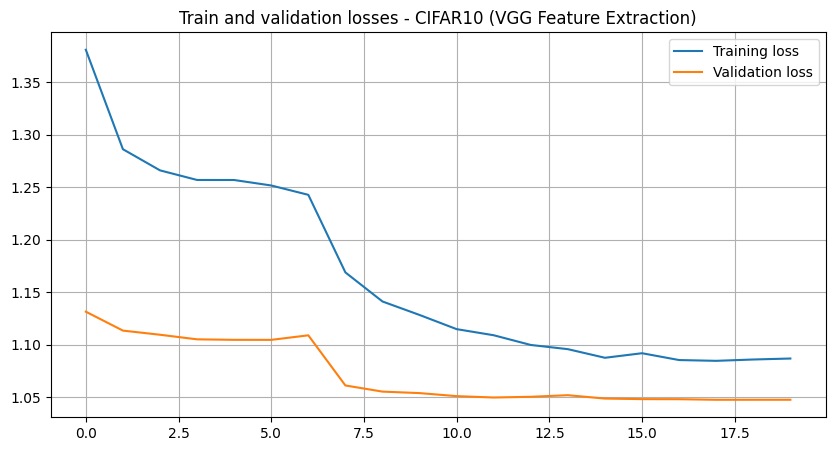

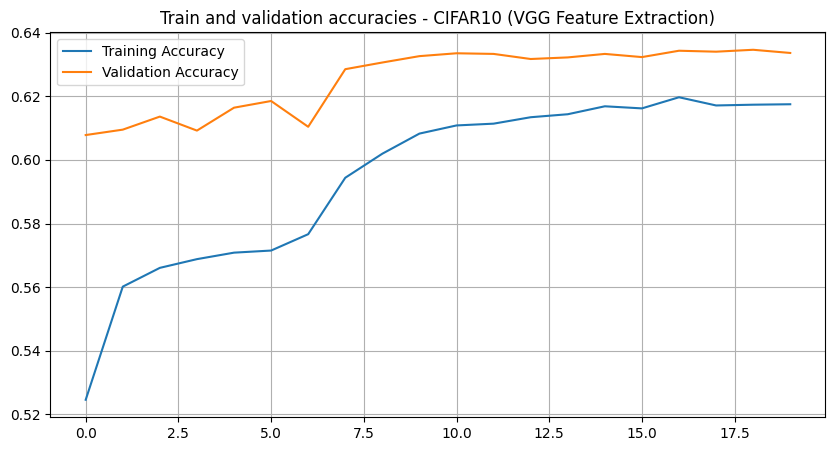

In [16]:
transform_vgg = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Download and load the training data and the validation (test) data for VGG
train_set_vgg = datasets.CIFAR10("DATA_CIFAR/", download=True, train=True, transform=transform_vgg)
trainLoader_vgg = torch.utils.data.DataLoader(train_set_vgg, batch_size=64, shuffle=True)

validation_set_vgg = datasets.CIFAR10("DATA_CIFAR/", download=True, train=False, transform=transform_vgg)
validationLoader_vgg = torch.utils.data.DataLoader(validation_set_vgg, batch_size=64, shuffle=True)

model_conv_vgg = models.vgg16(pretrained=True)
for param in model_conv_vgg.parameters():
    param.requires_grad = False

model_conv_vgg.classifier[6] = nn.Linear(4096, 10)
model_conv_vgg = model_conv_vgg.to(device)

criterion_conv_vgg = nn.CrossEntropyLoss()
optimizer_conv_vgg = optim.SGD(model_conv_vgg.classifier[6].parameters(), lr=0.001, momentum=0.9)
scheduler_conv_vgg = lr_scheduler.StepLR(optimizer_conv_vgg, step_size=7, gamma=0.1)

# Train model with feature extraction
model_conv_vgg, train_loss_conv_vgg, val_loss_conv_vgg, accuracy_total_train_conv_vgg, accuracy_total_val_conv_vgg, time_per_epoch_conv_vgg = train_model(model_conv_vgg, criterion_conv_vgg, optimizer_conv_vgg, scheduler_conv_vgg, num_epochs=20)

# Convert accuracy lists to numpy arrays
accuracy_total_train_conv_vgg = [acc.cpu().numpy() for acc in accuracy_total_train_conv_vgg]
accuracy_total_val_conv_vgg = [acc.cpu().numpy() for acc in accuracy_total_val_conv_vgg]

# Plot the loss curve for feature extraction (VGG)
plt.figure(figsize=(10, 5))
plt.plot(train_loss_conv_vgg, label="Training loss")
plt.plot(val_loss_conv_vgg, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (VGG Feature Extraction)")
plt.show()

# Plot the accuracy curve for feature extraction (VGG)
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_conv_vgg, label="Training Accuracy")
plt.plot(accuracy_total_val_conv_vgg, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (VGG Feature Extraction)")
plt.show()


### Step 3 : Fine-tuning with `VGG`
Here we fine-tune the entire `VGG` model on the `CIFAR-10` dataset.


Epoch 0/19
----------
train Loss: 0.7492 Acc: 0.7423
val Loss: 0.5432 Acc: 0.8140
Epoch 1/19
----------
train Loss: 0.4278 Acc: 0.8535
val Loss: 0.4366 Acc: 0.8471
Epoch 2/19
----------
train Loss: 0.3093 Acc: 0.8948
val Loss: 0.4078 Acc: 0.8646
Epoch 3/19
----------
train Loss: 0.2206 Acc: 0.9250
val Loss: 0.4049 Acc: 0.8704
Epoch 4/19
----------
train Loss: 0.1561 Acc: 0.9464
val Loss: 0.4164 Acc: 0.8708
Epoch 5/19
----------
train Loss: 0.1146 Acc: 0.9598
val Loss: 0.4632 Acc: 0.8692
Epoch 6/19
----------
train Loss: 0.0848 Acc: 0.9709
val Loss: 0.4981 Acc: 0.8720
Epoch 7/19
----------
train Loss: 0.0336 Acc: 0.9904
val Loss: 0.4828 Acc: 0.8820
Epoch 8/19
----------
train Loss: 0.0239 Acc: 0.9934
val Loss: 0.5032 Acc: 0.8834
Epoch 9/19
----------
train Loss: 0.0184 Acc: 0.9952
val Loss: 0.5326 Acc: 0.8825
Epoch 10/19
----------
train Loss: 0.0166 Acc: 0.9956
val Loss: 0.5490 Acc: 0.8842
Epoch 11/19
----------
train Loss: 0.0136 Acc: 0.9967
val Loss: 0.5665 Acc: 0.8828
Epoch 12/19
--

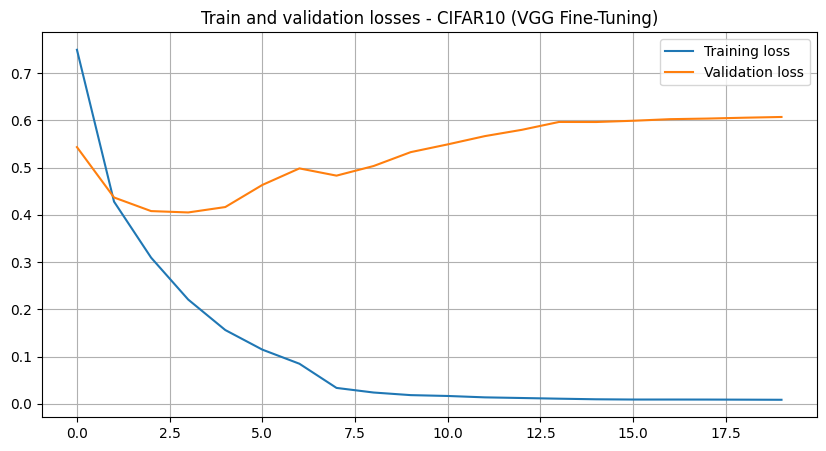

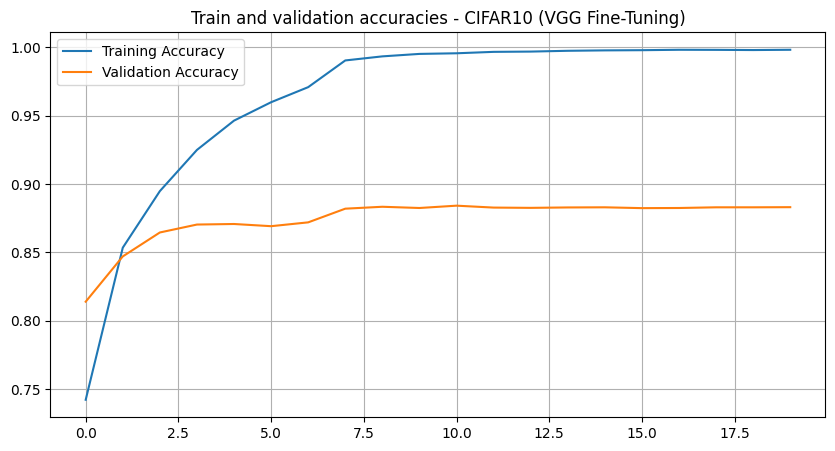

In [17]:
# Fine-tuning with VGG
model_ft_vgg = models.vgg16(pretrained=True)
model_ft_vgg.classifier[6] = nn.Linear(4096, 10)
model_ft_vgg = model_ft_vgg.to(device)

criterion_ft_vgg = nn.CrossEntropyLoss()
optimizer_ft_vgg = optim.SGD(model_ft_vgg.parameters(), lr=0.001, momentum=0.9)
scheduler_ft_vgg = lr_scheduler.StepLR(optimizer_ft_vgg, step_size=7, gamma=0.1)

# Train model with fine-tuning
model_ft_vgg, train_loss_ft_vgg, val_loss_ft_vgg, accuracy_total_train_ft_vgg, accuracy_total_val_ft_vgg, time_per_epoch_ft_vgg = train_model(model_ft_vgg, criterion_ft_vgg, optimizer_ft_vgg, scheduler_ft_vgg, num_epochs=20)

# Convert accuracy lists to numpy arrays
accuracy_total_train_ft_vgg = [acc.cpu().numpy() for acc in accuracy_total_train_ft_vgg]
accuracy_total_val_ft_vgg = [acc.cpu().numpy() for acc in accuracy_total_val_ft_vgg]

# Plot the loss curve for fine-tuning (VGG)
plt.figure(figsize=(10, 5))
plt.plot(train_loss_ft_vgg, label="Training loss")
plt.plot(val_loss_ft_vgg, label="Validation loss")
plt.legend()
plt.grid()
plt.title("Train and validation losses - CIFAR10 (VGG Fine-Tuning)")
plt.show()

# Plot the accuracy curve for fine-tuning (VGG)
plt.figure(figsize=(10, 5))
plt.plot(accuracy_total_train_ft_vgg, label="Training Accuracy")
plt.plot(accuracy_total_val_ft_vgg, label="Validation Accuracy")
plt.legend()
plt.grid()
plt.title("Train and validation accuracies - CIFAR10 (VGG Fine-Tuning)")
plt.show()


### Step 4 : Comparative analysis
We summarize the results in a comparative table.


In [18]:
# Create the final comparison DataFrame for all models (ResNet, SqueezeNet, VGG)
data = {
    "Model": [
        "From Scratch (ResNet18)", "ResNet18 (Feature Extraction)", "ResNet18 (Fine-Tuning)",
        "From Scratch (SqueezeNet)", "SqueezeNet (Feature Extraction)", "SqueezeNet (Fine-Tuning)",
        "From Scratch (VGG)", "VGG (Feature Extraction)", "VGG (Fine-Tuning)"
    ],
    "Number of Trainable Params": [
        sum(p.numel() for p in model_scratch.parameters() if p.requires_grad),
        sum(p.numel() for p in model_conv.parameters() if p.requires_grad),
        sum(p.numel() for p in model_ft.parameters() if p.requires_grad),
        sum(p.numel() for p in model_squeeze.parameters() if p.requires_grad),
        sum(p.numel() for p in model_conv_squeeze.parameters() if p.requires_grad),
        sum(p.numel() for p in model_ft_squeeze.parameters() if p.requires_grad),
        sum(p.numel() for p in model_vgg.parameters() if p.requires_grad),
        sum(p.numel() for p in model_conv_vgg.parameters() if p.requires_grad),
        sum(p.numel() for p in model_ft_vgg.parameters() if p.requires_grad)
    ],
    "Test Accuracy": [
        accuracy_total_val_scratch[-1].item(),
        accuracy_total_val_conv[-1].item(),
        accuracy_total_val_ft[-1].item(),
        accuracy_total_val_squeeze[-1].item(),
        accuracy_total_val_conv_squeeze[-1].item(),
        accuracy_total_val_ft_squeeze[-1].item(),
        accuracy_total_val_vgg[-1].item(),
        accuracy_total_val_conv_vgg[-1].item(),
        accuracy_total_val_ft_vgg[-1].item()
    ],
    "Training Time per Epoch": [
        time_per_epoch_scratch,
        time_per_epoch_conv,
        time_per_epoch_ft,
        time_per_epoch_squeeze,
        time_per_epoch_conv_squeeze,
        time_per_epoch_ft_squeeze,
        time_per_epoch_vgg,
        time_per_epoch_conv_vgg,
        time_per_epoch_ft_vgg
    ]
}

df = pd.DataFrame(data)
print(df)


                             Model  Number of Trainable Params  Test Accuracy  \
0          From Scratch (ResNet18)                      579402         0.7325   
1    ResNet18 (Feature Extraction)                        5130         0.4709   
2           ResNet18 (Fine-Tuning)                    11181642         0.8153   
3        From Scratch (SqueezeNet)                      729034         0.1000   
4  SqueezeNet (Feature Extraction)                        5130         0.1019   
5         SqueezeNet (Fine-Tuning)                      740554         0.7665   
6               From Scratch (VGG)                    33638218         0.1000   
7         VGG (Feature Extraction)                       40970         0.6336   
8                VGG (Fine-Tuning)                   134301514         0.8831   

   Training Time per Epoch  
0                19.556096  
1                21.722634  
2                25.539238  
3                24.277513  
4                19.641536  
5              

---


## Summary

In this lab, we compared three approaches to training convolutional neural networks on the `CIFAR-10` dataset using three different architectures: `ResNet18`, `SqueezeNet`, and `VGG16`. The three approaches evaluated were:

1. **Training from scratch** : Building and training a model from the ground up without any pre-trained weights.
2. **Feature extraction using a pre-trained model** : Using a pre-trained model and only training the final layers while keeping the rest of the network's weights fixed.
3. **Fine-tuning a pre-trained model** : Starting with a pre-trained model and retraining all layers to adapt it to the new dataset.

### `ResNet18`
- **From scratch** : `ResNet18` trained from scratch demonstrated a test accuracy of 73.25% with a training time of 19.56 seconds per epoch.
- **Feature extraction** : Using a pre-trained `ResNet18` and only training the final fully connected layers resulted in a lower test accuracy of 47.09% but slightly increased the training time to 21.72 seconds per epoch.
- **Fine-tuning** : Fine-tuning the entire `ResNet18` model yielded the highest accuracy of 81.53% with a training time of 25.54 seconds per epoch.

### `SqueezeNet`
- **From scratch** : `SqueezeNet` trained from scratch showed a test accuracy of 10.00%, similar to random guessing, and required 24.28 seconds per epoch for training.
- **Feature extraction** : Feature extraction with a pre-trained `SqueezeNet` slightly improved the test accuracy to 10.19% and reduced the training time to 19.64 seconds per epoch.
- **Fine-tuning** : Fine-tuning `SqueezeNet` significantly improved the test accuracy to 76.65%, with a training time of 24.44 seconds per epoch.

### `VGG16`
- **From scratch** : `VGG16` trained from scratch also demonstrated a test accuracy of 10.00% and required 24.79 seconds per epoch.
- **Feature extraction** : Feature extraction with a pre-trained `VGG16` considerably enhanced accuracy to 63.36% and reduced the training time to 22.06 seconds per epoch.
- **Fine-tuning** : Fine-tuning the entire `VGG16` model resulted in the highest accuracy of 88.31% but required the longest training time of 35.19 seconds per epoch due to the model's size.

### Comparative Analysis
- **Number of trainable parameters** : Training from scratch resulted in the highest number of trainable parameters for each model. Feature extraction reduced the number of trainable parameters significantly by freezing most layers. Fine-tuning increased the number of trainable parameters compared to feature extraction, leveraging the pre-trained weights effectively.
  - `ResNet18` : From scratch (579,402), Feature extraction (5,130), Fine-tuning (11,181,642)
  - `SqueezeNet` : From scratch (729,034), Feature extraction (5,130), Fine-tuning (740,554)
  - `VGG16` : From scratch (33,638,218), Feature extraction (40,970), Fine-tuning (134,301,514)
- **Test Accuracy**: Fine-tuning generally yielded the highest test accuracy across all models, followed by feature extraction, with training from scratch showing the lowest accuracy.
  - `ResNet18` : From scratch (73.25%), Feature extraction (47.09%), Fine-tuning (81.53%)
  - `SqueezeNet` : From scratch (10.00%), Feature extraction (10.19%), Fine-tuning (76.65%)
  - `VGG16` : From scratch (10.00%), Feature extraction (63.36%), Fine-tuning (88.31%)
- **Training Time per Epoch**: Training from scratch required the longest training time per epoch due to the necessity of learning all features from the data. Feature extraction significantly reduced training time as only the final layers were trained. Fine-tuning required more time than feature extraction but less than training from scratch, balancing between training all layers and leveraging pre-trained weights.
  - `ResNet18` : From scratch (19.56 s), Feature extraction (21.72 s), Fine-tuning (25.54 s)
  - `SqueezeNet` : From scratch (24.28 s), Feature extraction (19.64 s), Fine-tuning (24.44 s)
  - `VGG16` : From scratch (24.79 s), Feature extraction (22.06 s), Fine-tuning (35.19 s)

### Conclusion
The results demonstrate that transfer learning approaches (feature extraction and fine-tuning) provide substantial benefits in terms of reducing training time and improving test accuracy compared to training from scratch. Fine-tuning generally offers the best performance but at the cost of increased training time and complexity. The choice of model architecture and training approach depends on the specific requirements of computational efficiency and predictive performance. `ResNet18` and `VGG16`, with their deeper architectures, achieved higher accuracy, while `SqueezeNet`, with its efficient design, provided competitive accuracy and faster training times when fine-tuned.
